# STFV - Proposed Solution, Results

## Useful links

1. NumPy Docs - numpy.multiply: https://numpy.org/doc/stable/reference/generated/numpy.multiply.html

2. Itertools Docs - Functions creating iterators for efficient looping: https://docs.python.org/3/library/itertools.html#itertools.combinations

3. PuLP Docs - Optimization with PuLP: https://coin-or.github.io/pulp/

4. Seaborn Docs - Visualizing distributions of data: https://seaborn.pydata.org/tutorial/distributions.html

5. dev.to - Thales Bruno - Seaborn Multiple Plots Subplotting with matplotlib and seaborn: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

6. NumPy Docs - numpy.histogram_bin_edges (see "Bins"): https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges

7. Seaborn Docs - seaborn.kdeplot (see "bw_adjust"): https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot

8. Stack Overflow - Hide legend from seaborn pairplot: https://stackoverflow.com/questions/54781243/hide-legend-from-seaborn-pairplot

## Install PuLP

In [ ]:
!pip install pulp
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Obtaining the edges of a polytope given both its $\mathcal{V}$ and $\mathcal{H}$-representations

See [1].

In [ ]:
import numpy as np

# Algorithm 3
def check_vertex_algorithm_3(d, V, I, VF, i0, Si0, i1):
  Si0i1 = np.dot(VF, np.multiply(VF[i0], VF[i1]))
  for i in I:
    if i != i0 and i != i1 and Si0[i] >= d - 1 and np.isclose(Si0i1[i], Si0[i1]):
      return False
  return True

# Algorithm 2
def find_edges_from_vertex(d, V, I, VF, i0):
  edges = list()
  Si0 = np.dot(VF, VF[i0])
  for i1 in I:
    if i1 != i0 and Si0[i1] >= d - 1:
      if check_vertex_algorithm_3(d, V, I, VF, i0, Si0, i1):
        e = V[i1] - V[i0]
        edges.append(e / np.gcd.reduce(e))
  return edges


## Existence algorithm

In [ ]:
# Algorithm 5

def check_vertex_algorithm_5(d, V, I, H, J, VF, i):
  edges = find_edges_from_vertex(d, V, I, VF, i)
  for j in J:
    if VF[i, j] == 0:
      for e in edges:
        if np.dot(H[j], e) > 0:
          return False
  return True

# Algorithm 4

def find_vertices_in_facet(V, Hj):
  dot_Hj = lambda v: np.dot(v, Hj)
  dot_products = np.array([dot_Hj(v) for v in V])
  min = np.min(dot_products)
  VFj = np.array([1 if np.isclose(min, dp) else 0 for dp in dot_products])
  return VFj

def is_additive(P):
  id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, V, H = P
  I = range(nI)
  J = range(nJ)
  VF = np.empty((nI, nJ))
  for j in J:
    VF[:, j] = find_vertices_in_facet(V, H[j])
  for i in I:
    if check_vertex_algorithm_5(d, V, I, H, J, VF, i):
      return True
  return False


## Uniqueness algorithm

See [2], [3].

In [ ]:
import itertools as it
import pulp

def formal_dot_product(v, w):
  return sum([v[i]*w[i] for i in range(len(v))])

def is_uniquely_additive(P):
  id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, V, H = P
  I = range(nI)
  J = range(nJ)
  H = np.transpose(H)
  subsets_J = it.combinations(J, d)
  for s in subsets_J:
    B = H[:, list(s)]
    if np.isclose(np.abs(np.linalg.det(B)), 1.0):
      sorted_J = sorted(J, key = lambda j: j if j in list(s) else nJ + 1)
      sorted_H = H[:, list(sorted_J)]
      assert(np.array_equal(B, sorted_H[:, :d]))
      B_inv = np.linalg.inv(B)
      B_dual = np.transpose(B_inv)
      R = sorted_H[:, d:]
      R = np.dot(B_inv, R)
      if np.all(R <= 0):
        for i in range(d):
          s0 = (-1)*B_dual[:, i]
        
          # Model definition

          model = pulp.LpProblem(name="demazure-roots", sense=pulp.LpMaximize)
          variables = [pulp.LpVariable(name=f"x{j}", cat="Integer") for j in range(d)]
          for j in J:
            if j != i:
              model += formal_dot_product(sorted_H[:, j], variables) >= 0
            else:
              model += formal_dot_product(sorted_H[:, j], variables) == -1
          model += sum([0 if i == j else formal_dot_product(sorted_H[:, j], variables) for j in range(d)])
          model.solve()
          if model.status != 1:
            print("Model status for LP problem", id, i, "is not optimal.", "\n")
          
          s1 = np.array([v.value() for v in model.variables()])
          if not np.allclose(s0, s1):
            return False
        return True


## Classification

In [ ]:
import pandas as pd

data = np.load('data.npy', allow_pickle=True)
classifier = list()
for P in data:
  id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, V, H = P
  if is_additive(P):
    if is_uniquely_additive(P):
      classifier.append([id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, "Uniquely additive"])
    else:
      classifier.append([id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, "(Not uniquely) additive"])
  else:
    classifier.append([id, centrally_symmetric, d, deg, zero_barycentre, zero_dual_barycentre, vol, nI, nJ, "Non-additive"])
classifier = np.array(classifier, dtype=object)
classifier = pd.DataFrame(classifier, columns=["ID", "Centrally symmetric", "Dimension", "Degree", "Zero barycentre", "Zero dual barycentre", "Volume", "# Vertices", "# Facets", "Class"])
classifier.to_csv("classifier.csv", index=False)

## Plots

See [4], [5], [6], [7], [8].

updating: plots/ (stored 0%)
updating: plots/all.png (deflated 8%)
updating: plots/3.png (deflated 12%)
updating: plots/5.png (deflated 8%)
updating: plots/6.png (deflated 9%)
updating: plots/4.png (deflated 7%)
updating: plots/2.png (deflated 13%)


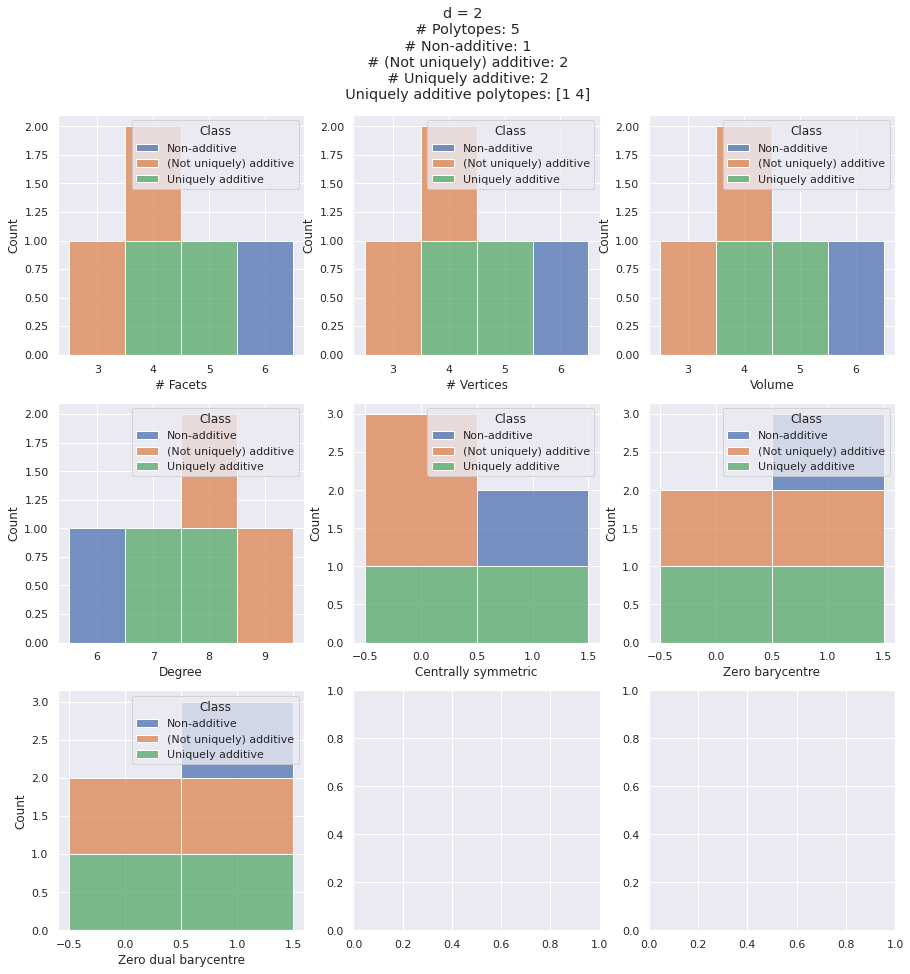

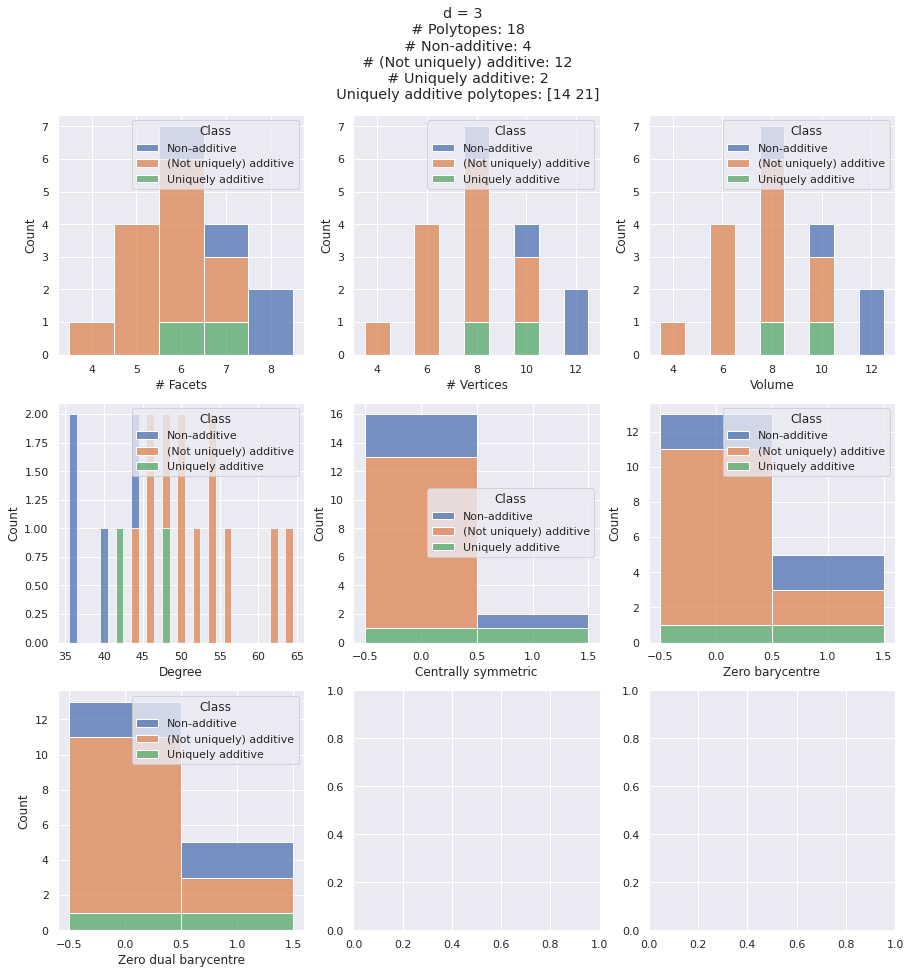

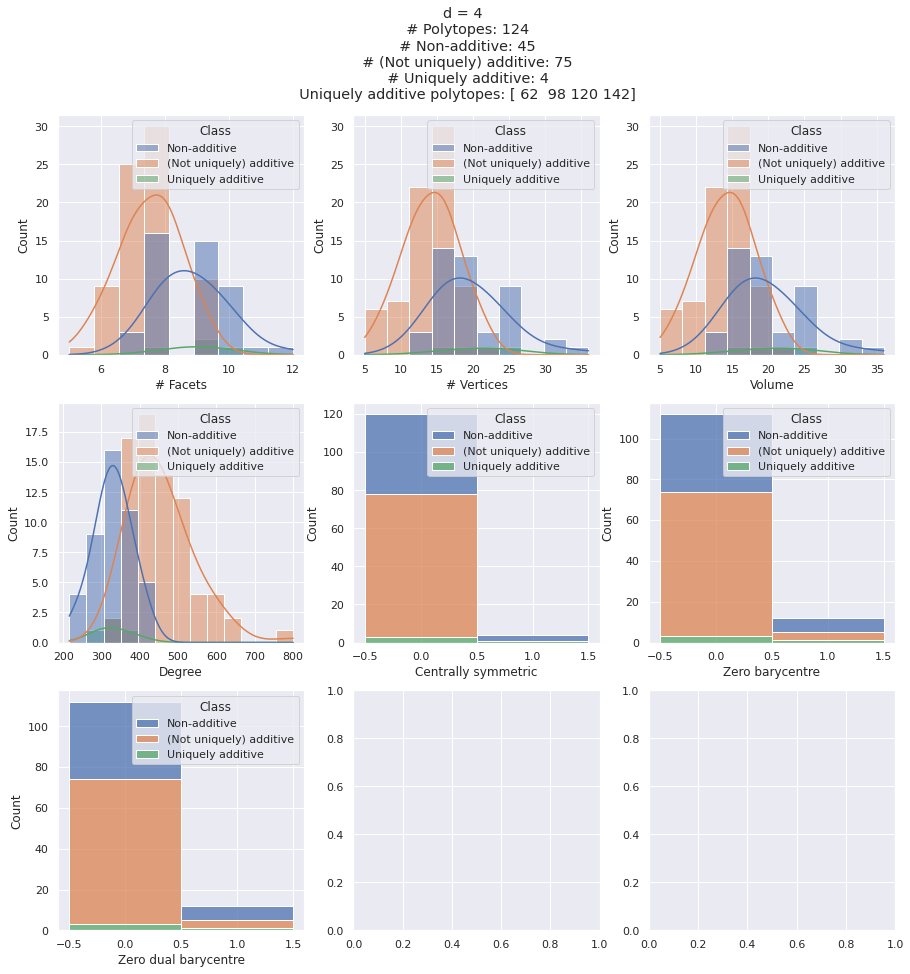

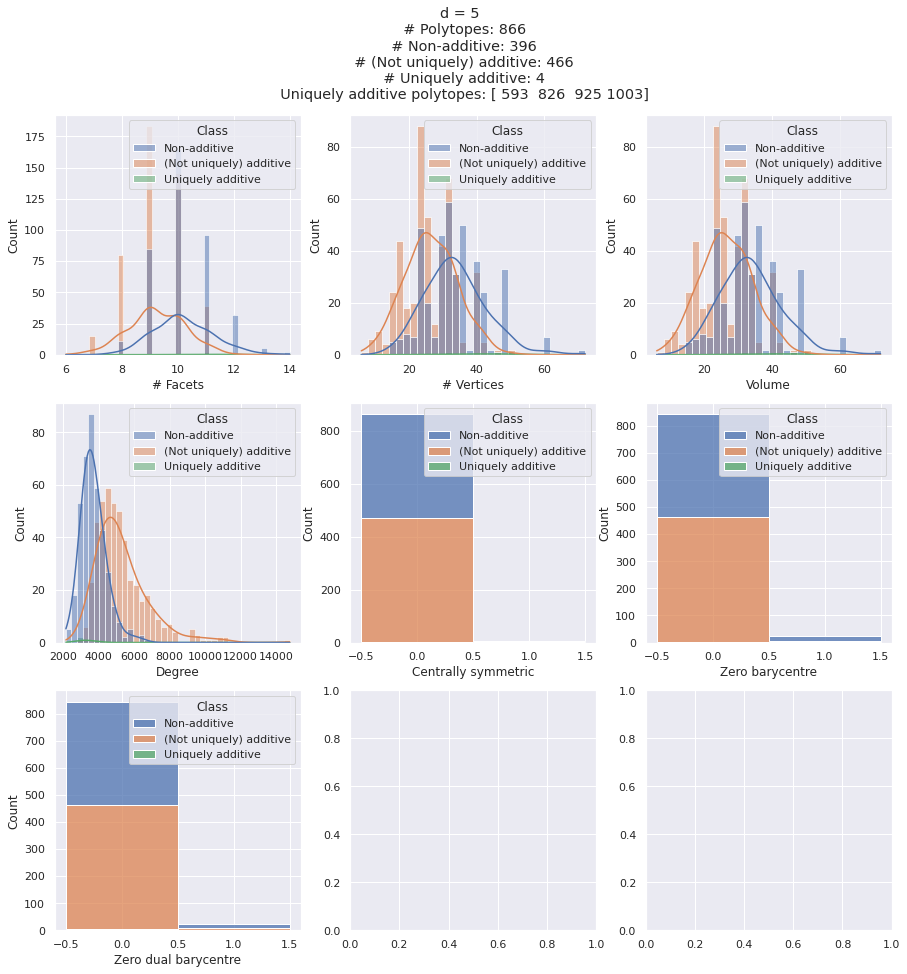

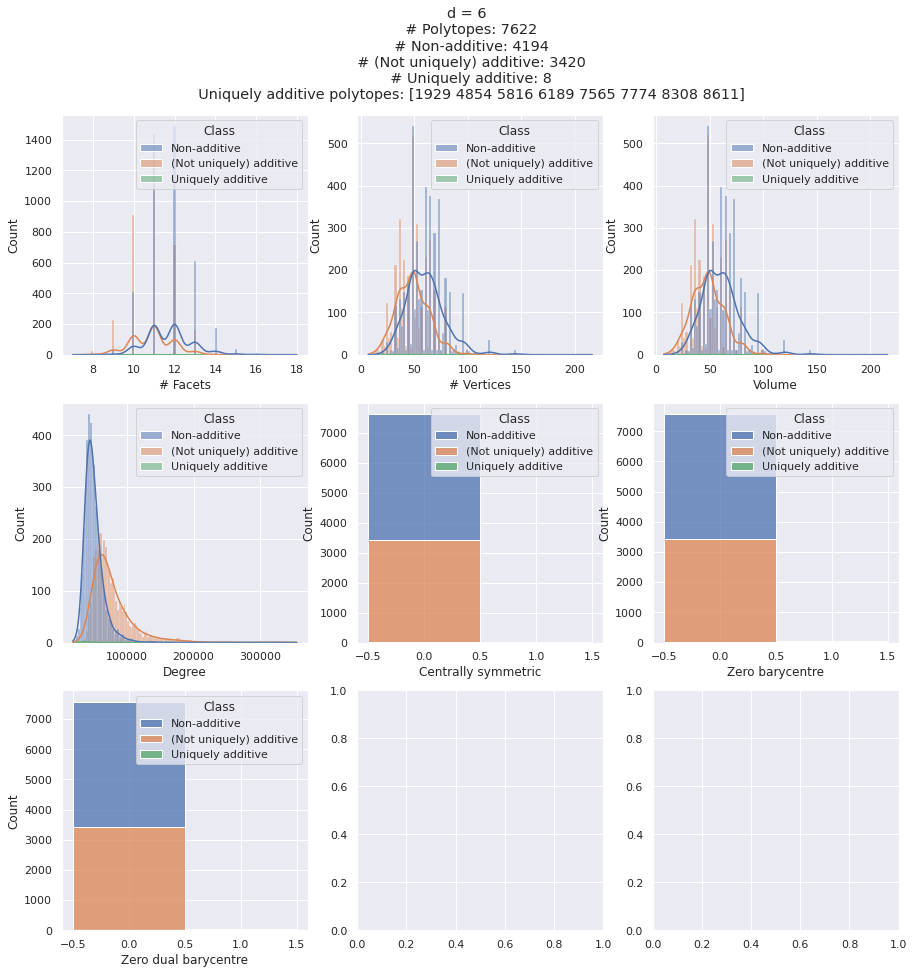

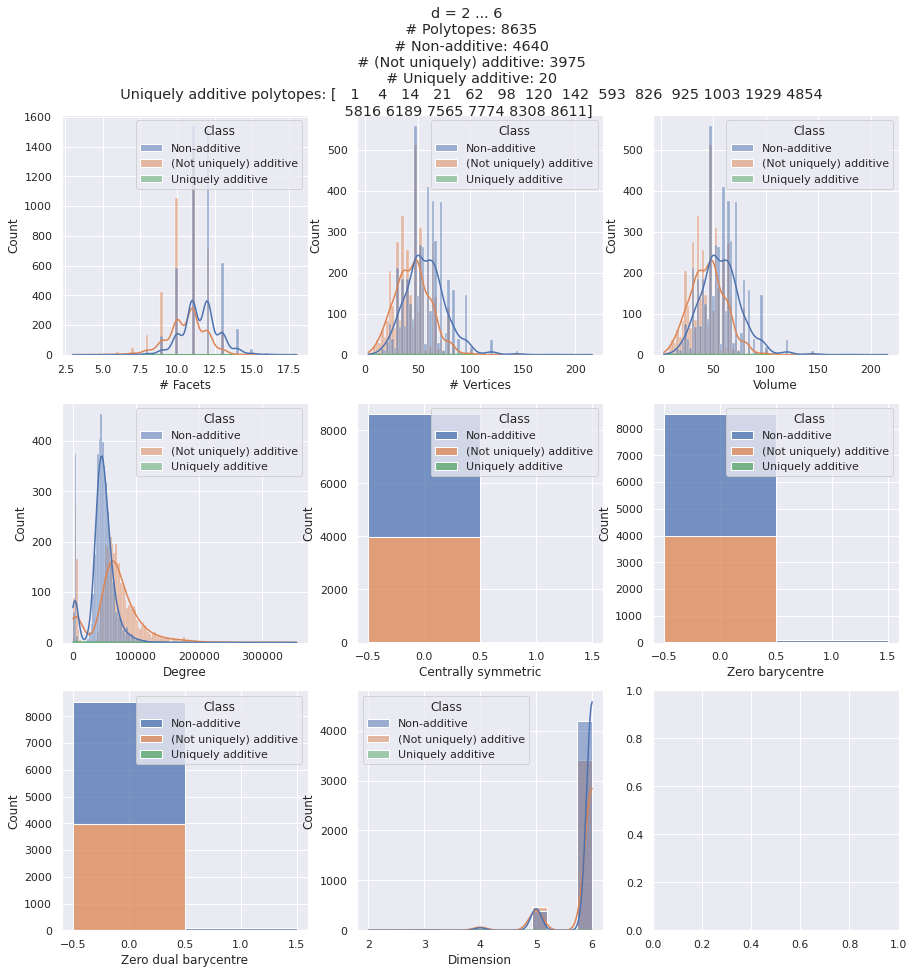

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plots histograms of classifier data for a fixed dimension d == 2 ... 6, or,
# if d == 7, plots histograms of all classifier data.
# Requires a directory "../plots/" in the runtime.
def plot(d, classifier_d):
  polytopes_count = classifier_d.shape[0]
  non_additive_count = classifier_d.query("Class == 'Non-additive'").shape[0]
  not_uniquely_additive_count = classifier_d.query("Class == '(Not uniquely) additive'").shape[0]
  uniquely_additive_count = classifier_d.query("Class == 'Uniquely additive'").shape[0]
  fig, axes = plt.subplots(3, 3, figsize=(15, 15))
  a = {
    "bins": "auto",
    "data": classifier_d,
    "hue": "Class",
    "hue_order": ["Non-additive", "(Not uniquely) additive", "Uniquely additive"]
  }
  a_boolean_x = {
    "discrete": True,
    "multiple": "stack"
  }
  a_non_boolean_x = {
    "discrete": (d <= 3),
    "kde": (d > 3),
    "kde_kws": {
        "bw_adjust": 1.5
    },
    "multiple": "stack" if d <= 3 else "layer"
  }
  sns.histplot(ax=axes[0,1], x="# Vertices", **a, **a_non_boolean_x)
  sns.histplot(ax=axes[0,2], x="Volume", **a, **a_non_boolean_x)
  sns.histplot(ax=axes[1,0], x="Degree", **a, **a_non_boolean_x)
  sns.histplot(ax=axes[1,1], x="Centrally symmetric", **a, **a_boolean_x)
  sns.histplot(ax=axes[1,2], x="Zero barycentre", **a, **a_boolean_x)
  sns.histplot(ax=axes[2,0], x="Zero dual barycentre", **a, **a_boolean_x)
  if d > 6:
    sns.histplot(ax=axes[2,1], x="Dimension", **a, **a_non_boolean_x)
  # Uncomment the following if you want to remove all legends except the first.
  #for row in axes:
  #  for col in row:
  #    col.legend([],[], frameon=False)    
  sns.histplot(ax=axes[0,0], x="# Facets", **a, **a_non_boolean_x)
  fig.suptitle(f'''d = {d if d <= 6 else "2 ... 6"}
  # Polytopes: {polytopes_count}
  # Non-additive: {non_additive_count}
  # (Not uniquely) additive: {not_uniquely_additive_count}
  # Uniquely additive: {uniquely_additive_count}
  Uniquely additive polytopes: {classifier_d.query("Class == 'Uniquely additive'")["ID"].values}''')
  fig.show()
  plt.savefig(f'''plots/{d if d <= 6 else "all"}''')

classifier = pd.read_csv("classifier.csv")

sns.set()

for d in range(2, 7):
  classifier_d = classifier.query("Dimension == @d")
  plot(d, classifier_d)

plot(7, classifier)

!zip -r plots.zip plots

In [ ]:
!zip -r plots.zip plots

  adding: plots/ (stored 0%)
  adding: plots/3.png (deflated 12%)
  adding: plots/all.png (deflated 7%)
  adding: plots/6.png (deflated 9%)
  adding: plots/5.png (deflated 8%)
  adding: plots/4.png (deflated 7%)
  adding: plots/2.png (deflated 13%)


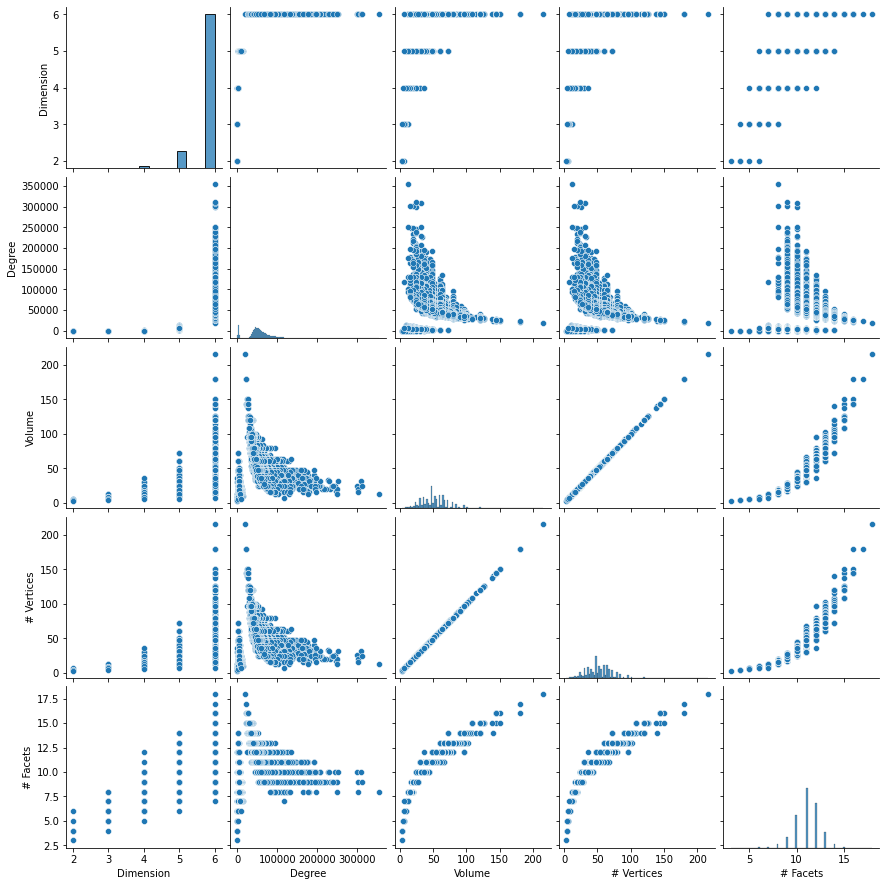

In [ ]:
classifier = pd.read_csv("classifier.csv", usecols=["Dimension", "Degree", "Volume", "# Vertices", "# Facets"])
sns.pairplot(classifier)

In [ ]:
for i in range(0, 10):
  for j in range(0, 10):
    for k in range(0, 10):
      for l in range(0, 10):
          if i + 2*j + 4*k + 6*l == 6:
            print(i, j, k, l)

0 0 0 1
0 1 1 0
0 3 0 0
2 0 1 0
2 2 0 0
4 1 0 0
6 0 0 0
